# Libraries

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import soundfile as sf

# Plotly Express
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

# PCM2PDM

In [2]:
class PCM2PDM():
    def __init__(self, data, fs_pcm, os):
        self.data = data
        self.fs = fs_pcm
        self.os = os
        self.size = len(data)

        self.os_done = False
        self.pdm_done = False

        self.data_os = np.empty(self.size*self.os)
        self.data_pdm = np.empty(self.size*self.os)

        self.process()

    def set_data(self, data): 
        self.data = data
        self.os_done = False
        self.pdm_done = False

    def oversample(self): 
        # self.data_os =  self.data.repeat(self.os)
        self.data_os = self.data
        self.os_done = True

    def pdm(self, qe=0):
        if not self.os_done: self.oversample()

        data = self.data_os
        n = len(data)
        pdm_stream = np.zeros(n)

        for i in range(n):
            if qe>=0: pdm_stream[i]=1
            else: pdm_stream[i]=-1
            qe += data[i]-pdm_stream[i]

        self.data_pdm = pdm_stream
        self.pdm_done = True
    
    def process(self):
        if not self.os_done: self.oversample()
        if not self.pdm_done: self.pdm(qe=0)

    def mag_plot(self):
        fig, axs = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(20,4))

        n = self.size
        fs = self.fs*self.os
        data = self.data

        t = np.arange(n)/fs
        f = np.arange(n/2)*fs/n
        
        mag = 20*np.log10(np.abs(np.fft.fft(data)) / n)[:n // 2]

        axs[0].plot(t, data, 'k')
        axs[1].plot(f, mag, 'k')

        axs[0].set_title('Time domain')
        axs[0].set_ylabel('Amplitude')
        axs[0].set_xlabel('Time (s)')
        axs[1].set_title('Frequency domain')
        axs[1].set_ylabel('Magnitude')
        axs[1].set_xlabel('Frequency (Hz)')

        plt.show()

    def pdm_plot(self):
        np.seterr(divide = 'ignore') 

        fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(20,10))

        os = self.os
        fs = self.fs

        pdm_fs = os*fs

        data_os = self.data_os
        data_pdm = self.data_pdm

        n = len(data_os)
        t = np.arange(n)/pdm_fs
        f = np.arange(n/2)*pdm_fs/n

        mag_os = 20*np.log10(np.abs(np.fft.fft(data_os)) / n)[:n // 2]
        mag_pdm = 20*np.log10(np.abs(np.fft.fft(data_pdm)) / n)[:n // 2]

        axs[0,0].step(t, data_os, 'k')
        axs[0,1].step(t, data_pdm, 'k')
        axs[1,0].plot(f, mag_os, 'k')
        axs[1,1].plot(f, mag_pdm, 'k')

        axs[0,0].set_ylabel('Amplitude')
        axs[0,1].set_ylabel('Amplitude')
        axs[1,0].set_ylabel('Magnitude')
        axs[1,1].set_ylabel('Magnitude')

        axs[0,0].set_xlabel('Time (s)')
        axs[0,1].set_xlabel('Time (s)')
        axs[1,0].set_xlabel('Frequency (Hz)')
        axs[1,1].set_xlabel('Frequency (Hz)')

        axs[0,0].set_title('Time domain (PCM-OS)')
        axs[0,1].set_title('Time domain (PDM)')
        axs[1,0].set_title('Frequency domain (PCM-OS)')
        axs[1,1].set_title('Frequency domain (PDM)')

        plt.show()       

# PDM2PCM

In [2]:
class Integrator:
	def __init__(self):
		self.acc=0
	
	def process(self, data_in):
		self.acc += data_in
        # check for overflow/underflow
        # if (acc >= maxVal/2)
        #     acc = acc - maxVal;
        # elseif acc < -maxVal/2
        #     acc = acc + maxVal;
        # end
		return self.acc
		
class Comb:
	def __init__(self):
		self.previous = 0
		self.actual = 0
	
	def process(self, data_in):
		self.previous = self.actual
		self.actual = data_in
        # check for overflow/underflow
        # if (diffSignal < -maxVal/2)
        #     diffSignal = diffSignal+maxVal;
        # elseif (diffSignal >=maxVal/2)
        #     diffSignal = diffSignal-maxVal;
        # end
		return self.actual - self.previous

class CIC:
    def __init__(self, stages=1, decimation_factor=16, differential_delay=1):
        self.N = stages
        self.R = decimation_factor
        self.M = differential_delay
        self.gain = (self.R*self.M)**self.N

        self.integrator_stages = [Integrator() for _ in range(self.N)]
        self.comb_stages = [Comb() for _ in range(self.N)]

    def process(self, data_in): 
        data_out = []
        
        for (index, sample) in enumerate(data_in):
            acc = sample
        
            for i in range(self.N): # integration step
                acc = self.integrator_stages[i].process(acc)
            
            if (index % self.R) == 0: # decimation
                for c in range(self.N): # comb step
                    acc = self.comb_stages[c].process(acc)
                data_out.append(acc/self.gain)
        
        return data_out

class PDM2PCM():
    def __init__(self, data, fs_pdm, os, stages=1):
        self.data = data
        self.fs = fs_pdm
        self.os = os
        self.size = len(data)
        self.cic = CIC(stages=stages, decimation_factor=self.os, differential_delay=1)

        self.out_done = False

        self.data_pcm = np.empty(self.size//self.os)

        self.process()

    def set_data(self, data): 
        self.data = data
        self.out_done = False

    def process(self):
        if not self.out_done: self.data_pcm = self.cic.process(self.data)
        self.out_done = True

    def mag_plot(self):
        fig, axs = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(20,4))
        
        data = self.data_pcm
        n = len(data)
        fs = self.fs//self.os

        t = np.arange(n)/fs
        f = np.arange(n/2)*fs/n
        
        mag = 20*np.log10(np.abs(np.fft.fft(data)) / n)[:n // 2]

        axs[0].plot(t, data, 'k')
        axs[1].plot(f, mag, 'k')

        axs[0].set_title('Time domain')
        axs[0].set_ylabel('Amplitude')
        axs[0].set_xlabel('Time (s)')
        axs[1].set_title('Frequency domain')
        axs[1].set_ylabel('Magnitude')
        axs[1].set_xlabel('Frequency (Hz)')

        plt.show()

# Tests

In [3]:
wd = r"C:/Users/levyg/Documents/MEGA/Repositories/mems2sd_esp32/python/PDMSignalProcessing/"
fname = "pure_pdm_4480000hz"
data, fs = sf.read(wd+fname, channels=1, samplerate=int(4480000/(2*16)),format='RAW', endian='LITTLE', subtype='PCM_16', dtype=np.int16)

In [4]:
def serialize(data):
    byte_stream = data.view(dtype=np.uint8)
    bit_stream = np.unpackbits(byte_stream.ravel(), axis=0)
    return bit_stream

In [5]:
pdm_stream = serialize(data)

In [6]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=False)

fig.add_trace(
    go.Scatter(y=pdm_stream[:10000], line_shape='hv'),
    row=1, col=1
)

fig.update_layout(height=400, width=700)
fig.update_yaxes(title_text="", showgrid=True)
fig.update_xaxes(title_text="", showgrid=True, matches='x')

fig['layout']['yaxis1']['title']='Bit'
fig['layout']['xaxis1']['title']='Samples'

fig.show()

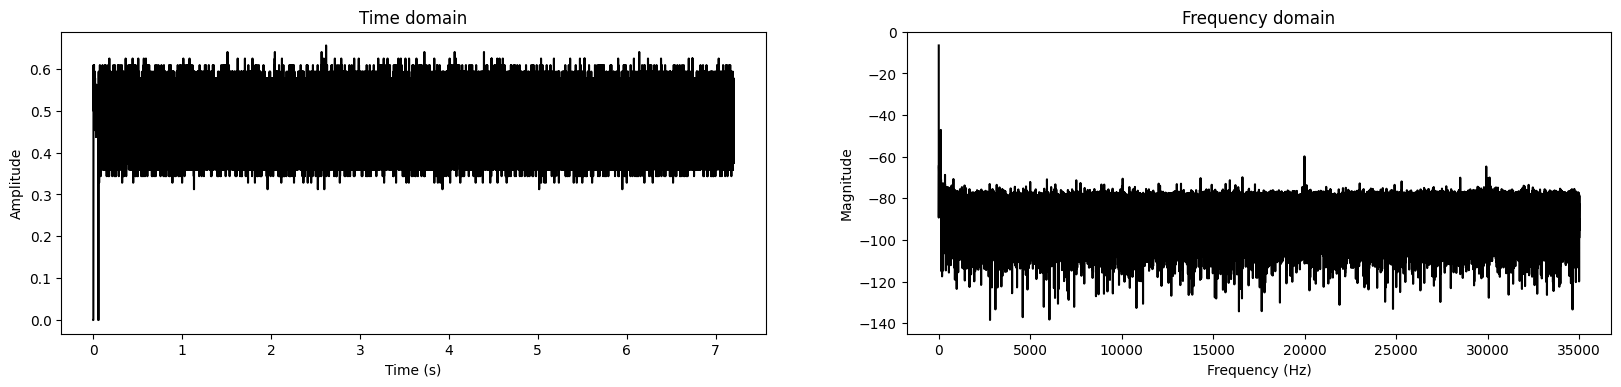

In [7]:
fs_pdm = 4480000
os = 64
fs_pcm = fs_pdm/os

pdm2pcm = PDM2PCM(pdm_stream, fs_pdm=fs_pdm, os=os)
pdm2pcm.mag_plot()